## Imports

The main thing here is importing all the Tensorflow Keras stuff.
Additionally, scikit-learn is needed to split the data into train/test sets.

In [76]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
seed = 0

os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from skmultilearn.model_selection import IterativeStratification

In [5]:
from gensim.models import Word2Vec

In [6]:
sys.path.append("../scripts/")
from ml_utils import MultiLabelClassification

In [7]:
tf.random.set_seed(1)
np.random.seed(1)
random.seed(1)


# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)

## Data preprocessing

In [8]:
df = pd.read_csv("../songs-ml-10pct.csv")

In [9]:
df.lyrics.str.split().apply(len).describe()

count    109817.000000
mean        164.423332
std          82.906356
min           1.000000
25%         109.000000
50%         153.000000
75%         206.000000
max        2392.000000
Name: lyrics, dtype: float64

In [10]:
input_length = df.lyrics.str.split().apply(len).max()
print(input_length)

2392


In [11]:
for col in df.columns[1:]:
    print(f"{col}: {100*df[col].mean():.2g}%")

black: 17%
death: 35%
heavy: 14%
power: 18%
thrash: 16%


In [12]:
X = df.lyrics.values
y = df[df.columns[1:]].values
num_labels = y.shape[1]
labels = df.columns[1:]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(87853,) (21964,) (87853, 5) (21964, 5)


## Text pre-processing

The lyrics are tokenized, then converted into sequences to generate a zero-padded $n$-by-$m$ feature matrix $X$ where $n$ is the number of songs and $m$ is the maximum token length (word count) among songs.

In [14]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r\'')
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.index_word) + 1
print(vocab_size)

139998


In [15]:
def texts_to_sequences(texts, maxlen=input_length):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=maxlen, padding='post')
    return padded

In [16]:
padded_train = texts_to_sequences(X_train)
padded_test = texts_to_sequences(X_test)

In [17]:
print(padded_train.shape, padded_test.shape)

(87853, 2392) (21964, 2392)


In [18]:
padded_train

array([[   117,      3,     60, ...,      0,      0,      0],
       [  1644,      9,   1054, ...,      0,      0,      0],
       [   204,     10,    288, ...,      0,      0,      0],
       ...,
       [  3203,  18297,   3334, ...,      0,      0,      0],
       [139993,   1070,   4948, ...,      0,      0,      0],
       [     2,    989,    169, ...,      0,      0,      0]])

#### Resize sequences to a more manageable length

In [17]:
# def resize_sequences(X_old, y_old, length):
#     X_new = []
#     y_new = []
#     for i, row in enumerate(X_old):
#         new_rows = np.split(row, np.arange(0, len(row), length))[1:]
#         for new_row in new_rows:
#             new_row_padded = np.pad(new_row, (0, input_length_short - len(new_row)))
#             if sum(new_row_padded) > 0:
#                 X_new.append(new_row_padded)
#                 y_new.append(y_old[i])
#     X_new = np.array(X_new)
#     y_new = np.array(y_new)
#     return X_new, y_new

# input_length_short = 100
# padded_train, y_train = resize_sequences(padded_train, y_train, input_length_short)
# padded_test, y_test = resize_sequences(padded_test, y_test, input_length_short)
# print(padded_train.shape, y_train.shape, padded_test.shape, y_test.shape)

#### Sample weights to deal with imbalanced dataset

In [19]:
# label_weights = 1 / y_train.sum(axis=0)
# label_weights /= label_weights.sum()
# print(label_weights)

# sample_weights = (y_train * label_weights).mean(axis=1)
# sample_weights[sample_weights == 0] = sample_weights.mean()
# for i in range(20):
#     print(y_train[i], sample_weights[i])

## Glove pre-trained word embeddings

#### Load word vectors into a dictionary

Adapted from [a Keras tutorial](https://keras.io/examples/nlp/pretrained_word_embeddings/).

In [20]:
# path_to_glove_file = "E:/Projects/metallyrics/data/glove.840B.300d.txt"
path_to_glove_file = "E:/Projects/metallyrics/data/glove.6B.100d.txt"

embedding_vectors = {}
with open(path_to_glove_file, encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embedding_vectors[word] = coefs
print(len(embedding_vectors))
print(len(list(embedding_vectors.values())[0]))

400001
100


#### Embedding matrix

In [21]:
embedding_dim = len(list(embedding_vectors.values())[0])
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_vectors.get(word)
    if embedding_vector is not None:
        if len(embedding_vector) > 0:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
            continue
    misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 64229 words (75768 misses)


In [22]:
print(embedding_matrix.shape)

(139998, 100)


#### Neural network input embedding layer

In [23]:
embedding_layer = layers.Embedding(
    vocab_size,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

#### Word replacement

In [24]:
# vector = embedding_vectors['satan']
# # dist = np.linalg.norm(embedding_matrix - vector, axis=1)
# dist = -np.dot(embedding_matrix, vector)
# nearest = [(tokenizer.index_word.get(i, 0), dist[i]) for i in  dist.argsort()[1:11]]
# nearest

In [25]:
# from nltk.corpus import stopwords

# ignore = stopwords.words('english')

# np.linalg.norm(embedding_matrix, axis=1)

In [26]:
# def get_nearest_word(word, method='euclidean'):
#     if word not in ignore and isinstance(word, str):
#         if word in embedding_vectors.keys():
#             vector = embedding_vectors[word]
#             if len(vector) > 0:
#                 if method == 'euclidean':
#                     dist = np.linalg.norm(embedding_matrix - vector, axis=1)
#                     i = dist.argsort()[1]
#                 elif method == 'cosine':
#                     embedding_norm = np.linalg.norm(embedding_matrix, axis=1)
#                     vector_norm = np.linalg.norm(vector)
#                     dist = np.dot(embedding_matrix, vector) / (embedding_norm * vector_norm)
#                     dist = np.nan_to_num(dist, 0)
#                     i = dist.argsort()[-2]
#                 else:
#                     assert ValueError(f"invalid method {method}")
#                 nearest = tokenizer.index_word.get(i, 0)
#                 if nearest not in ignore:
#                     return nearest
#     return word

# words = [tokenizer.index_word.get(i, 0) for i in padded_train[111]]
# new_words = [get_nearest_word(word, 'cosine') for word in words]
# new_row = [tokenizer.word_index.get(word, 0) for word in new_words]
# print(words[:20])
# print(new_words[:20])

## Baseline convolutional neural network (single-label)

We start with a baseline model trained on a single output label.
Death metal is the least imbalanced label, appearing in about a third of samples,
so it's a good first choice just to approach the problem as a standard binary classification problem.
Best to keep this baseline as simple as possible,
so no fancy architecture beyond a single convolutional layer and a full-connected layer.

In [62]:
def create_baseline_model(bias_initializer=None):
    model = Sequential()
    model.add(embedding_layer)
    model.add(layers.Conv1D(filters=128, kernel_size=4, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Flatten())
    model.add(layers.Dense(256))
    if bias_initializer is not None:
        model.add(layers.Dense(1, activation='sigmoid', bias_initializer=bias_initializer))
    else:
        model.add(layers.Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=1e-4)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [72]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
    ax1.plot(history['accuracy'])
    ax1.plot(history['val_accuracy'])
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'validation'], loc='upper left')
    ax2.plot(history['loss'])
    ax2.plot(history['val_loss'])
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    plt.show()

#### Setting a better initial bias to account for label imbalance

With the default initialization of neural network parametrs,
the model won't make predictions that scale appropriately with the probability of positive cases.
If only a third of samples are positive, an untrained model should output prediction probabilities close to one-third.
We can check this by evaluating the untrained model and checking its loss on the training set.
Following the advice of [this tutorial](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#optional_set_the_correct_initial_bias),
we can explicitly initialize the model with a bias of $\log(n_1, n_0)$,
where $n_1$ and $n_0$ are the number of positives and negatives,
resulting in a initial loss is closer to the expected value of $-p \log(p) - (1 - p) \log(1 - p) \approx 0.65$.

In [28]:
p = y_train[:, 1].mean()
-p * np.log(p) - (1 - p) * np.log(1 - p)

0.6482004788134439

In [29]:
cnn_model = create_baseline_model()
print(cnn_model.summary())

cnn_pred = cnn_model.predict(padded_test[:10])
cnn_loss, cnn_acc = cnn_model.evaluate(padded_train, y_train[:, 1], verbose=0)

print("Initial prediction:")
print(cnn_pred)
print(f"Initial loss: {cnn_loss:.4f}")
print(f"Initial accuracy: {cnn_acc:.4f}")

Initial prediction:
[[0.8090844 ]
 [0.86126995]
 [0.78433776]
 [0.8850009 ]
 [0.8566829 ]
 [0.8562336 ]
 [0.895985  ]
 [0.88748235]
 [0.8782779 ]
 [0.84077275]]
Initial loss: 1.3022
Initial accuracy: 0.3513


In [35]:
neg, pos = np.bincount(y_train[:, 1])
init_bias = np.log(pos / neg)
print(f"New initial bias: {init_bias:.4f}")
bias_initializer = keras.initializers.Constant(np.log([pos / neg]))

New initial bias: -0.6137


In [40]:
cnn_model = create_baseline_model(bias_initializer=bias_initializer)
print(cnn_model.summary())

cnn_pred = cnn_model.predict(padded_test[:10])
cnn_loss, cnn_acc = cnn_model.evaluate(padded_train, y_train[:, 1], verbose=0)

print("Initial prediction:")
print(cnn_pred)
print(f"Initial loss: {cnn_loss:.4f}")
print(f"Initial accuracy: {cnn_acc:.4f}")

In [44]:
cnn_model.save_weights('initial_weights')

In [45]:
# cnn_model = Sequential()
# cnn_model.add(embedding_layer)
# cnn_model.add(layers.Conv1D(filters=128, kernel_size=4, activation='relu'))
# # cnn_model.add(layers.BatchNormalization())
# # cnn_model.add(layers.MaxPooling1D(pool_size=2))
# # cnn_model.add(layers.Conv1D(filters=64, kernel_size=4, activation='relu'))
# # cnn_model.add(layers.BatchNormalization())
# cnn_model.add(layers.GlobalMaxPooling1D())
# cnn_model.add(layers.Flatten())
# cnn_model.add(layers.Dense(256))
# cnn_model.add(layers.Dense(1, activation='sigmoid'))
# # cnn_model.add(layers.Dense(num_labels, activation='sigmoid'))
# opt = Adam(learning_rate=1e-4)
# cnn_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
# print(cnn_model.summary())

#### Train on small batch

In [63]:
cnn_model = create_baseline_model(bias_initializer=bias_initializer)
print(cnn_model.summary())

cnn_history = cnn_model.fit(padded_train[::100], y_train[::100, 1], epochs=64, batch_size=1024, validation_split=0.2, verbose=2)
cnn_pred = cnn_model.predict(padded_test)
cnn_loss, cnn_acc = cnn_model.evaluate(padded_test, y_test[:, 1], verbose=0)
print(f"loss: {cnn_loss:.4f}\nacc: {cnn_acc:.4f}")

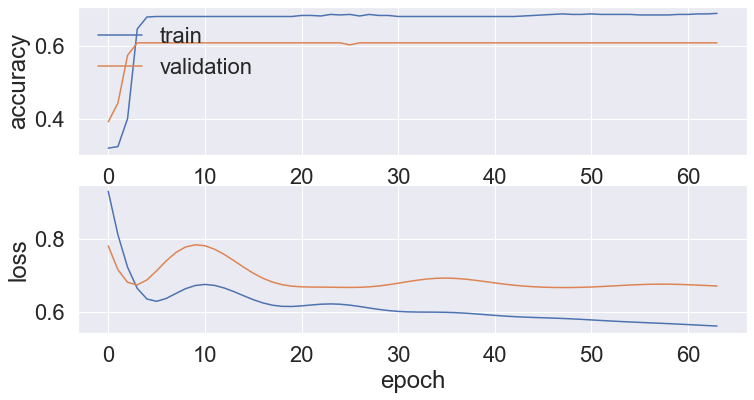

In [66]:
plot_history(cnn_history.history)

#### Train on larger batch

Five times larger training set, to check that more data --> more fitting.
Indeed the training loss and accuracy scale well.
Validation metrics don't improve as significantly,
but we'll deal with generalization later.

In [74]:
cnn_model = create_baseline_model(bias_initializer=bias_initializer)
print(cnn_model.summary())

cnn_history = cnn_model.fit(padded_train[::20], y_train[::20, 1], epochs=64, batch_size=1024, validation_split=0.2, verbose=2)
cnn_pred = cnn_model.predict(padded_test)
cnn_loss, cnn_acc = cnn_model.evaluate(padded_test, y_test[:, 1], verbose=0)
print(f"loss: {cnn_loss:.4f}\nacc: {cnn_acc:.4f}")

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         13999800  
                                                                 
 conv1d_9 (Conv1D)           (None, None, 128)         51328     
                                                                 
 global_max_pooling1d_9 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 flatten_9 (Flatten)         (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 256)               33024     
                                                                 
 dense_19 (Dense)            (None, 1)                 257       
                                                      

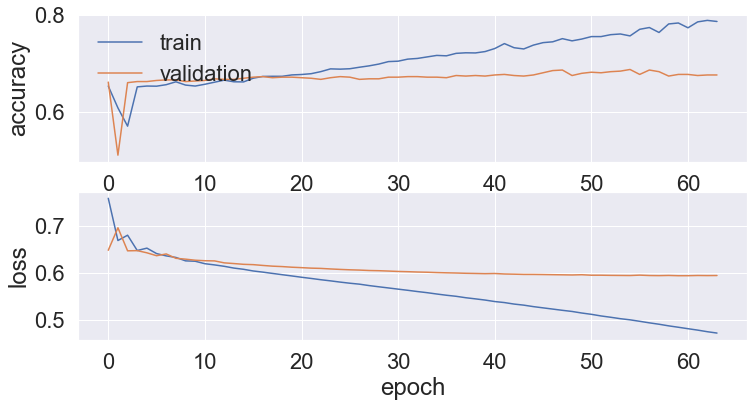

In [75]:
plot_history(cnn_history.history)

#### Evaluation metrics

In [78]:
def plot_cm(true, pred, p=0.5):
    cm = confusion_matrix(true, pred > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])
    print('Positives: ', np.sum(cm[1]))
    return cm

True Negatives:  12295
False Positives:  1763
False Negatives:  5194
True Positives:  2712
Positives:  7906


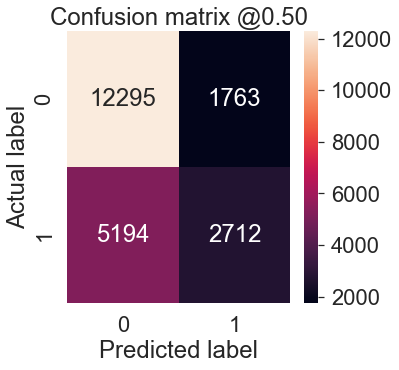

In [84]:
plot_cm(y_test[:, 1], cnn_pred.flatten())

#### Train on (almost) full dataset

The goal now is to intentionally overfit to the full training set
before making tweaks to regularize for generalizability.

In [73]:
cnn_model = create_baseline_model(bias_initializer=bias_initializer)
print(cnn_model.summary())

cnn_history = cnn_model.fit(padded_train[::3], y_train[::3, 1], epochs=64, batch_size=1024, validation_split=0.2, verbose=1)
cnn_pred = cnn_model.predict(padded_test)
cnn_loss, cnn_acc = cnn_model.evaluate(padded_test, y_test[:, 1], verbose=0)
print(f"loss: {cnn_loss:.4f}\nacc: {cnn_acc:.4f}")

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         13999800  
                                                                 
 conv1d_8 (Conv1D)           (None, None, 128)         51328     
                                                                 
 global_max_pooling1d_8 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 flatten_8 (Flatten)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               33024     
                                                                 
 dense_17 (Dense)            (None, 1)                 257       
                                                      

KeyboardInterrupt: 

In [ ]:
plot_history(cnn_history.history)

In [68]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=10,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=False,
    )
]

In [49]:
# cnn_history = cnn_model.fit(padded_train[::10], y_train[::10], epochs=64, batch_size=32, validation_split=0.2, callbacks=callbacks, verbose=1)
# cnn_pred = cnn_model.predict(padded_test)
# cnn_loss, cnn_acc = cnn_model.evaluate(padded_test, y_test, verbose=0)
# print(f"loss: {cnn_loss:.4f}\nacc: {cnn_acc:.4f}")

### LSTM

In [35]:
lstm_model = Sequential()
lstm_model.add(embedding_layer)
lstm_model.add(layers.SpatialDropout1D(0.2))
lstm_model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=False)))
lstm_model.add(layers.Dropout(0.2))
lstm_model.add(layers.BatchNormalization())
lstm_model.add(layers.Dense(num_labels, activation='sigmoid'))
opt = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         9570000   
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 100)        0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                      

In [36]:
lstm_history = lstm_model.fit(padded_train, y_train, epochs=64, batch_size=32, validation_split=0.2, verbose=1)
lstm_pred = lstm_model.predict(padded_test)
lstm_loss, lstm_acc = lstm_model.evaluate(padded_test, y_test, verbose=0)
print(f"loss: {lstm_loss:.4f}\nacc: {lstm_acc:.4f}")

Epoch 1/64
2580/2580 [==============================] - 125s 48ms/step - loss: 0.4844 - accuracy: 0.3388 - val_loss: 0.4449 - val_accuracy: 0.3795
Epoch 2/64
2580/2580 [==============================] - 131s 51ms/step - loss: 0.4490 - accuracy: 0.3805 - val_loss: 0.4387 - val_accuracy: 0.3953
Epoch 3/64
2580/2580 [==============================] - 134s 52ms/step - loss: 0.4407 - accuracy: 0.3966 - val_loss: 0.4341 - val_accuracy: 0.3836
Epoch 4/64
2580/2580 [==============================] - 150s 58ms/step - loss: 0.4338 - accuracy: 0.4062 - val_loss: 0.4321 - val_accuracy: 0.4125
Epoch 5/64
2580/2580 [==============================] - 156s 60ms/step - loss: 0.4285 - accuracy: 0.4133 - val_loss: 0.4297 - val_accuracy: 0.4173
Epoch 6/64
2580/2580 [==============================] - 176s 68ms/step - loss: 0.4239 - accuracy: 0.4194 - val_loss: 0.4283 - val_accuracy: 0.4162
Epoch 7/64
2580/2580 [==============================] - 172s 67ms/step - loss: 0.4196 - accuracy: 0.4248 - val_loss: 0

KeyboardInterrupt: 

In [40]:
lstm_model = model
lstm_pred = lstm_model.predict(padded_test)
lstm_loss, lstm_acc = lstm_model.evaluate(padded_test, y_test, verbose=0)
print(f"loss: {lstm_loss:.4f}\nacc: {lstm_acc:.4f}")

loss: 0.4437
acc: 0.4171


In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
ax1.plot(lstm_history.history['accuracy'])
ax1.plot(lstm_history.history['val_accuracy'])
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')
ax2.plot(lstm_history.history['loss'])
ax2.plot(lstm_history.history['val_loss'])
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
plt.show()


Average binary classification scores:
  balanced_accuracy   0.62 +/- 0.07
  precision           0.57 +/- 0.09
  recall              0.31 +/- 0.23
  f1                  0.39 +/- 0.20

Multi-label classification metrics:
  accuracy      0.31
  precision     0.58
  recall        0.36
  f1            0.44
  hamming loss  0.98

ROC AUC scores:
  black     : 0.802
  death     : 0.754
  heavy     : 0.772
  power     : 0.785
  thrash    : 0.707
  macro-avg : 0.764 +/- 0.033


array([0.11514997, 0.36893153, 0.14259663, 0.19652411, 0.16775662])

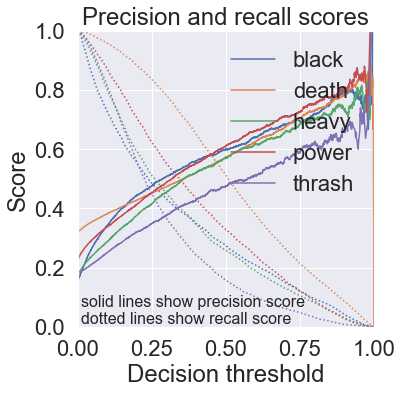

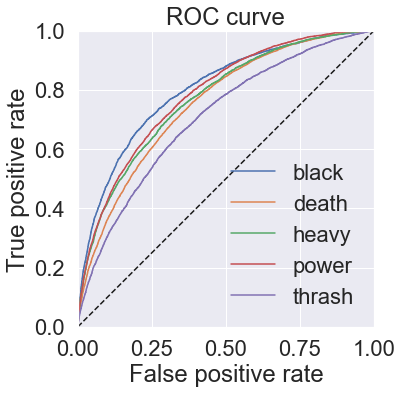

In [43]:
lstm_mlc = MultiLabelClassification(y_test, pred=lstm_pred, labels=labels)
lstm_mlc.print_report()
lstm_mlc.plot_precision_recall_curve()
lstm_mlc.plot_roc_curve()
lstm_mlc.best_thresholds()

In [44]:
lstm_mlc_tuned = MultiLabelClassification(y_test, pred=lstm_pred, labels=labels, threshold=lstm_mlc.best_thresholds())
lstm_mlc_tuned.print_report()


Average binary classification scores:
  balanced_accuracy   0.70 +/- 0.05
  precision           0.38 +/- 0.14
  recall              0.69 +/- 0.05
  f1                  0.49 +/- 0.12

Multi-label classification metrics:
  accuracy      0.38
  precision     0.41
  recall        0.71
  f1            0.52
  hamming loss  1.50

ROC AUC scores:
  black     : 0.802
  death     : 0.754
  heavy     : 0.772
  power     : 0.785
  thrash    : 0.707
  macro-avg : 0.764 +/- 0.033


In [45]:
lstm_pred.round().astype(int)[:20]

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0]])

In [46]:
lstm_mlc_tuned.pred_class[:20]

array([[1, 1, 0, 0, 0],
       [1, 0, 1, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0],
       [1, 1, 0, 0, 1],
       [1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0]])

In [47]:
y_test[:20]

array([[0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0]], dtype=int64)

### LSTM trained with sample weights

In [51]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [54]:
lstm_model_2 = Sequential()
lstm_model_2.add(embedding_layer)
lstm_model_2.add(layers.SpatialDropout1D(0.2))
lstm_model_2.add(layers.Bidirectional(layers.LSTM(128, return_sequences=False)))
lstm_model_2.add(layers.Dropout(0.2))
lstm_model_2.add(layers.BatchNormalization())
lstm_model_2.add(layers.Dense(num_labels, activation='sigmoid'))
opt = Adam(learning_rate=0.1)
lstm_model_2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
print(lstm_model_2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         9570000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, None, 100)        0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                      

In [55]:
lstm_2_history = lstm_model_2.fit(
    padded_train,
    y_train,
    sample_weight=sample_weights,
    epochs=64,
    batch_size=32,
    callbacks=[early_stopping],
    validation_split=0.2,
    verbose=1
)
lstm_2_pred = lstm_model_2.predict(padded_test)
lstm_2_loss, lstm_2_acc = lstm_model_2.evaluate(padded_test, y_test, verbose=0)
print(f"loss: {lstm_2_loss:.4f}\nacc: {lstm_2_acc:.4f}")

Epoch 1/64
2580/2580 [==============================] - 152s 58ms/step - loss: 0.0291 - accuracy: 0.2020 - val_loss: 0.0270 - val_accuracy: 0.2774
Epoch 2/64
2580/2580 [==============================] - 147s 57ms/step - loss: nan - accuracy: 0.2433 - val_loss: nan - val_accuracy: 0.3233
Epoch 3/64
2580/2580 [==============================] - 147s 57ms/step - loss: nan - accuracy: 0.3176 - val_loss: nan - val_accuracy: 0.3233
Epoch 4/64
2580/2580 [==============================] - 159s 62ms/step - loss: nan - accuracy: 0.3176 - val_loss: nan - val_accuracy: 0.3233
Epoch 5/64
2580/2580 [==============================] - 162s 63ms/step - loss: nan - accuracy: 0.3176 - val_loss: nan - val_accuracy: 0.3233
Epoch 6/64
2580/2580 [==============================] - 172s 66ms/step - loss: nan - accuracy: 0.3176 - val_loss: nan - val_accuracy: 0.3233
Epoch 7/64
2580/2580 [==============================] - 173s 67ms/step - loss: nan - accuracy: 0.3176 - val_loss: nan - val_accuracy: 0.3233
Epoch 8

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
ax1.plot(lstm_2_history.history['accuracy'])
ax1.plot(lstm_2_history.history['val_accuracy'])
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')
ax2.plot(lstm_2_history.history['loss'])
ax2.plot(lstm_2_history.history['val_loss'])
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
plt.show()

In [ ]:
lstm_2_mlc = MultiLabelClassification(y_test, pred=lstm_2_pred, labels=labels)
lstm_2_mlc.print_report()
lstm_2_mlc.plot_precision_recall_curve()
lstm_2_mlc.plot_roc_curve()
lstm_2_mlc.best_thresholds()

In [ ]:
lstm_2_mlc_tuned = MultiLabelClassification(y_test, pred=lstm_2_pred, labels=labels, threshold=lstm_2_mlc.best_thresholds())
lstm_2_mlc_tuned.print_report()

In [ ]:
lstm_2_pred.round().astype(int)[:20]

In [ ]:
lstm_2_mlc_tuned.pred_class[:20]

In [ ]:
y_test[:20]